In [1]:
import random
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Number conversion

In [5]:
def bin_to_dec(bArray, length=16, min_val=-20, max_val=20):
    int_val = 0
    for i in range(length):
        int_val = (int_val << 1) | bArray[i]
    max_int_val = (1 << length) - 1
    return min_val + (float(int_val) / max_int_val) * (max_val - min_val)

def dec_to_bin(value, min_val, max_val, length):
    normalized_val = (value - min_val) / (max_val - min_val)
    int_val = int(normalized_val * ((1 << length) - 1))
    bArray = np.zeros(length, dtype=int)
    for i in range(length - 1, -1, -1):
        bArray[i] = int_val & 1
        int_val >>= 1
    return bArray

#### Initialize Population

In [6]:
def init_pop(popSize, geneLen):
    population = np.random.randint(0, 2, (popSize, geneLen))
    return population

#### Fitness function

In [7]:
def sse(y, y_hat):
    total = 0.001
    err = y - y_hat
    total += np.sum(err ** 2)
    return total

def cal_fitness(x, y, w, b):
    y_hat = (w * x) + b
    return 1 / sse(y, y_hat)

#### Selection

In [8]:
def roulette_wheel_selection(fitness, popSize, pool_size):
    total = np.sum(fitness) + 0.00001
    
    # if total <= 0:
        # raise ValueError("Total fitness is zero or negative. Cannot perform roulette wheel selection.")
    
    cummFitness = np.zeros(popSize)
    
    # Calculate cumulative fitness
    temp = 0
    for i in range(popSize):
        cummFitness[i] = ((fitness[i] / total) * 100) + temp
        temp = cummFitness[i]
    
    pool = np.zeros(pool_size, dtype=int)

    # Perform selection
    for j in range(pool_size):
        rand_num = random.uniform(1, 100)
        temp = 1
        for i in range(popSize):
            if temp <= rand_num < cummFitness[i]:
                pool[j] = i
                break
            temp = cummFitness[i] + 1
    
    return pool

#### Crossover

In [9]:
def crossover(parent1, parent2, length, cp=0.7):
    child1 = np.zeros(length, dtype=int)
    child2 = np.zeros(length, dtype=int)
    
    if random.uniform(0, 1) <= cp:
        temp = random.randint(1, length - 1) 
        child1[:temp] = parent1[:temp]
        child2[:temp] = parent2[:temp]
        child1[temp:] = parent2[temp:]
        child2[temp:] = parent1[temp:]
    else:
        child1[:] = parent1[:]
        child2[:] = parent2[:]

    return child1, child2

#### Mutation

In [10]:
def mutation(chromosome, length, mp=0.1):
    for i in range(length):
        if random.uniform(0, 1) < mp:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

#### Hyperparameters

In [11]:
geneLen = 16
popSize = 1000
generation = 1000
pool_size = 100
cross_prob = 0.7
mut_prob = 0.1
min_val = -5
max_val = 5
fitness = np.full(popSize, -1.1)

In [12]:
# Points
X = np.array([1, 2, 3, 4, 5])
Y = np.array([2, 3, 5, 7, 8])

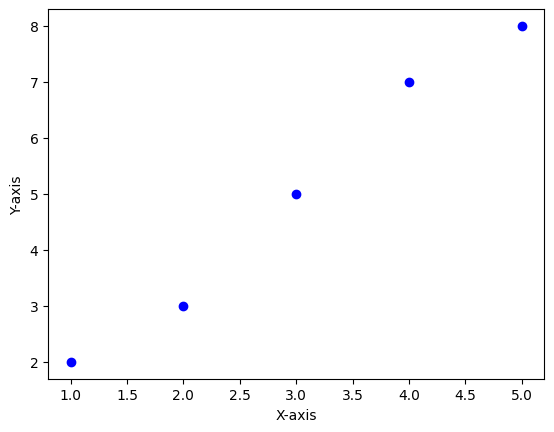

In [13]:
plt.scatter(X, Y, color='blue', label='Data points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

#### GA

In [14]:
pop_weight = init_pop(popSize, geneLen)
pop_bias = init_pop(popSize, geneLen)

for i in range(popSize):
    w = bin_to_dec(pop_weight[i], geneLen, min_val, max_val)
    b = bin_to_dec(pop_bias[i], geneLen, min_val, max_val)
    fitness[i] = cal_fitness(X, Y, w, b)

for i in tqdm(range(generation)):
    child_weight = np.full((pool_size, geneLen), -1)
    child_bias = np.full((pool_size, geneLen), -1)
    
    # Selection
    pool = roulette_wheel_selection(fitness, popSize, pool_size)
    
    # Crossover
    for j in range(0, pool_size, 2):
        c1_weight, c2_weight = crossover(pop_weight[pool[j]], pop_weight[pool[j+1]], geneLen)
        c1_bias, c2_bias = crossover(pop_bias[pool[j]], pop_bias[pool[j+1]], geneLen)
        
        child_weight[j] = c1_weight
        child_weight[j+1] = c2_weight
        child_bias[j] = c1_bias
        child_bias[j+1] = c2_bias

    # Mutation
    for j in range(pool_size):
        child_weight[j] = mutation(child_weight[j], geneLen)
        child_bias[j] = mutation(child_bias[j], geneLen)

    # Replace Population
    for j in range(pool_size):
        pop_weight[pool[j]] = child_weight[j]
        pop_bias[pool[j]] = child_bias[j]

    # Calculate Fitness
    for i in range(popSize):
        w = bin_to_dec(pop_weight[i], geneLen, min_val, max_val)
        b = bin_to_dec(pop_bias[i], geneLen, min_val, max_val)
        fitness[i] = cal_fitness(X, Y, w, b)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.86it/s]


(1.16739147020676, 2.774471656366827)

#### Result before Fitness Scalling

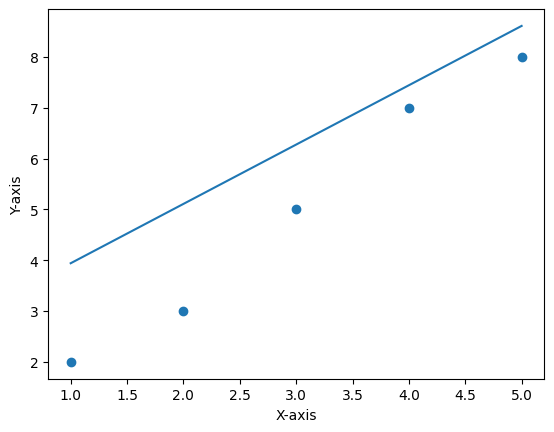

In [21]:
w = bin_to_dec(pop_weight[np.argmax(fitness)], geneLen, min_val, max_val)
b = bin_to_dec(pop_bias[np.argmax(fitness)], geneLen, min_val, max_val)
y_hat = (X * w) + b

plt.scatter(X, Y)
plt.plot(X, y_hat)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [25]:
def linear_scaling(fitness, c=2):
    f_avg = np.mean(fitness)
    f_max = np.max(fitness) + 0.0000001
    f_min = np.min(fitness)

    a = (f_avg * (c - 1)) / (f_max - f_avg)
    b = (f_avg * (f_max - (c * f_avg))) / (f_max - f_avg)

    if f_min > (-1 * (b/a)):
        return a * fitness + b
    else:
        a = f_avg / (f_max - f_avg)
        b = (-1 * f_min * f_avg) / (f_max - f_avg)
        return a * fitness + b

#### GA with fitness scalling

In [27]:
pop_weight = init_pop(popSize, geneLen)
pop_bias = init_pop(popSize, geneLen)

for i in range(popSize):
    w = bin_to_dec(pop_weight[i], geneLen, min_val, max_val)
    b = bin_to_dec(pop_bias[i], geneLen, min_val, max_val)
    fitness[i] = cal_fitness(X, Y, w, b)

for i in tqdm(range(generation)):
    child_weight = np.full((pool_size, geneLen), -1)
    child_bias = np.full((pool_size, geneLen), -1)

    scaled_fitness = linear_scaling(fitness, c=4)
    
    # Selection
    pool = roulette_wheel_selection(scaled_fitness, popSize, pool_size)
    
    # Crossover
    for j in range(0, pool_size, 2):
        c1_weight, c2_weight = crossover(pop_weight[pool[j]], pop_weight[pool[j+1]], geneLen)
        c1_bias, c2_bias = crossover(pop_bias[pool[j]], pop_bias[pool[j+1]], geneLen)
        
        child_weight[j] = c1_weight
        child_weight[j+1] = c2_weight
        child_bias[j] = c1_bias
        child_bias[j+1] = c2_bias

    # Mutation
    for j in range(pool_size):
        child_weight[j] = mutation(child_weight[j], geneLen)
        child_bias[j] = mutation(child_bias[j], geneLen)

    # Replace Population
    for j in range(pool_size):
        pop_weight[pool[j]] = child_weight[j]
        pop_bias[pool[j]] = child_bias[j]

    # Calculate Fitness
    for i in range(popSize):
        w = bin_to_dec(pop_weight[i], geneLen, min_val, max_val)
        b = bin_to_dec(pop_bias[i], geneLen, min_val, max_val)
        fitness[i] = cal_fitness(X, Y, w, b)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.06it/s]


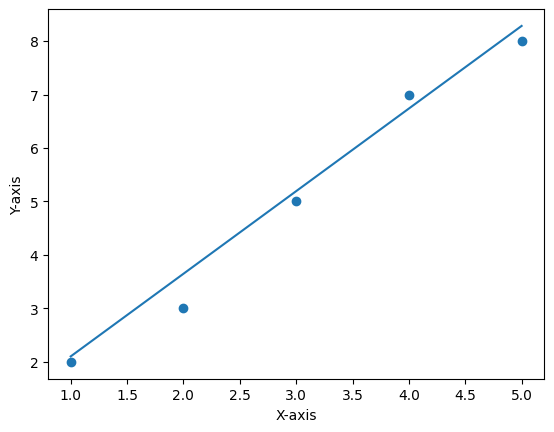

In [28]:
w = bin_to_dec(pop_weight[np.argmax(fitness)], geneLen, min_val, max_val)
b = bin_to_dec(pop_bias[np.argmax(fitness)], geneLen, min_val, max_val)
y_hat = (X * w) + b

plt.scatter(X, Y)
plt.plot(X, y_hat)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()